In [1]:
from google.colab import files
import io

print("👇 Por favor, clique no botão abaixo para fazer o upload do arquivo .csv")
uploaded = files.upload()

# Pega o nome do primeiro arquivo enviado automaticamente
if len(uploaded) > 0:
    ARQUIVO_CSV = list(uploaded.keys())[0]
    print(f"\n✅ Sucesso! Arquivo carregado: '{ARQUIVO_CSV}'")
else:
    print("❌ Nenhum arquivo foi carregado.")

👇 Por favor, clique no botão abaixo para fazer o upload do arquivo .csv


Saving Portfolio_tickmill_correlacao03_listOfTrades_Portfolio.csv to Portfolio_tickmill_correlacao03_listOfTrades_Portfolio.csv

✅ Sucesso! Arquivo carregado: 'Portfolio_tickmill_correlacao03_listOfTrades_Portfolio.csv'


In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# 1. Carregamento e Preparação
# Substitua pelo caminho do seu arquivo
filename = ARQUIVO_CSV
df = pd.read_csv(filename)

# Converter datas e criar coluna de data pura (sem hora)
df['Open time'] = pd.to_datetime(df['Open time'], dayfirst=True)
df['Date'] = df['Open time'].dt.date

# PIVOT: Transforma lista de trades em Curva de Equity Diária por estratégia
# Preenche dias sem trade com 0
daily_pnl = df.pivot_table(index='Date', columns='Strategy name (Global)', values='Profit/Loss (Global)', aggfunc='sum').fillna(0)

# 2. Estatísticas Anuais (Assume 252 dias úteis)
ann_mean = daily_pnl.mean() * 252
ann_cov = daily_pnl.cov() * 252

# 3. Otimização (Maximizar Sharpe Ratio)
def negative_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0):
    p_ret = np.sum(mean_returns * weights)
    p_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return - (p_ret - risk_free_rate) / p_vol

num_assets = len(daily_pnl.columns)
args = (ann_mean, ann_cov)
# Restrição: Soma dos pesos = 1 (100% do capital alocado)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
# Limites: Pesos entre 0 e 1 (Sem alavancagem infinita, sem short na alocação)
bounds = tuple((0, 1) for asset in range(num_assets))
init_guess = [1./num_assets] * num_assets

opt_results = minimize(negative_sharpe, init_guess, args=args, method='SLSQP', bounds=bounds, constraints=constraints)

# 4. Resultados
results_df = pd.DataFrame({
    'Strategy': daily_pnl.columns,
    'Peso Ideal (%)': np.round(opt_results.x * 100, 2)
}).sort_values(by='Peso Ideal (%)', ascending=False)

print("--- Alocação Otimizada de Carteira ---")
print(results_df)

# Comparativo de Performance
sharpe_individual = (ann_mean / (daily_pnl.std() * np.sqrt(252))).mean()
p_ret_opt = np.sum(ann_mean * opt_results.x)
p_vol_opt = np.sqrt(np.dot(opt_results.x.T, np.dot(ann_cov, opt_results.x)))
sharpe_opt = p_ret_opt / p_vol_opt

print(f"\nSharpe Médio (Estratégias Isoladas): {sharpe_individual:.2f}")
print(f"Sharpe do Portfólio Otimizado: {sharpe_opt:.2f}")
print(f"Melhoria de Eficiência: {((sharpe_opt/sharpe_individual)-1)*100:.1f}%")

--- Alocação Otimizada de Carteira ---
                                      Strategy  Peso Ideal (%)
39  Us500-M15-DT_Strategy 9.3.80_101110100.ex5           15.86
38  Us500-M15-DT_Strategy 3.5.77_101110100.ex5            8.39
15  Us100-M15-DT_Strategy 2.4.69_101010100.ex5            6.03
11   Us100-H1-ST_Strategy 5.8.56_101015100.ex5            5.40
17  Us100-M15-DT_Strategy 6.1.45_101010100.ex5            5.21
10   Us100-H1-ST_Strategy 5.7.65_101015100.ex5            5.10
5    Us100-H1-ST_Strategy 3.7.58_101015100.ex5            3.96
16  Us100-M15-DT_Strategy 4.5.69_101010100.ex5            3.67
20   Us30-H1-ST_Strategy 10.1.59_101215100.ex5            3.57
24    Us30-H1-ST_Strategy 5.8.86_101215100.ex5            3.33
22    Us30-H1-ST_Strategy 5.1.47_101215100.ex5            2.91
13  Us100-H1-ST_Strategy 8.13.79_101015100.ex5            2.90
23    Us30-H1-ST_Strategy 5.1.74_101215100.ex5            2.87
7   Us100-H1-ST_Strategy 4.22.74_101015100.ex5            2.72
0   Us100-H1-ST_


--- TABELA DE ALOCAÇÃO PARA O MT5 ---
                                  Strategy  Peso Ideal (%)  Lote Original  Lote Otimizado
Us500-M15-DT_Strategy 9.3.80_101110100.ex5           15.86            5.0            5.98
Us500-M15-DT_Strategy 3.5.77_101110100.ex5            8.39            5.0            3.69
Us100-M15-DT_Strategy 2.4.69_101010100.ex5            6.03            5.0            0.62
 Us100-H1-ST_Strategy 5.8.56_101015100.ex5            5.40            5.0            0.78
Us100-M15-DT_Strategy 6.1.45_101010100.ex5            5.21            5.0            1.16
 Us100-H1-ST_Strategy 5.7.65_101015100.ex5            5.10            5.0            0.89
 Us100-H1-ST_Strategy 3.7.58_101015100.ex5            3.96            5.0            0.64
Us100-M15-DT_Strategy 4.5.69_101010100.ex5            3.67            5.0            0.40
 Us30-H1-ST_Strategy 10.1.59_101215100.ex5            3.57            5.0            0.27
  Us30-H1-ST_Strategy 5.8.86_101215100.ex5            3.33   

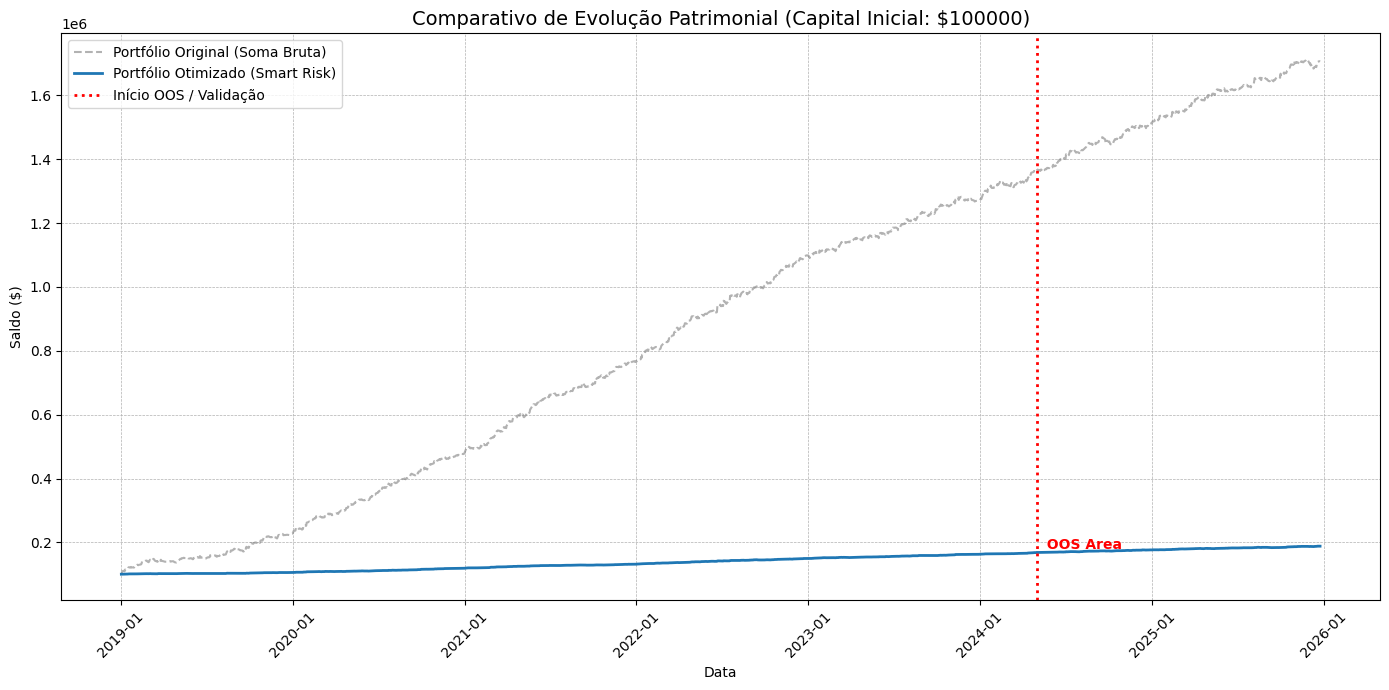

In [3]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ==========================================
# CONFIGURAÇÕES DO USUÁRIO (O INPUT DO TRADER)
# ==========================================
FILENAME = ARQUIVO_CSV
CAPITAL_INICIAL = 100000        # Seu capital total em USD/BRL
INICIO_OOS = '2024-05-02'       # Data onde começa o Out-of-Sample (Validação)
RISK_TOLERANCE_DD = 0.10        # Aceitamos até 25% de DD sobre o capital alocado para cada estratégia

# ==========================================
# 1. PROCESSAMENTO DE DADOS
# ==========================================
df = pd.read_csv(FILENAME)
df['Open time'] = pd.to_datetime(df['Open time'], dayfirst=True)
df['Date'] = df['Open time'].dt.date

# Identificar o Lote Original (Moda ou Média do tamanho operado)
original_lots = df.groupby('Strategy name (Global)')['Size'].median()

# Pivot para Curva de PnL Diária
daily_pnl = df.pivot_table(index='Date', columns='Strategy name (Global)', values='Profit/Loss (Global)', aggfunc='sum').fillna(0)

# Calcular Drawdown Máximo Histórico ($) de cada estratégia original
# Isso é vital para dimensionar o lote baseando-se no risco
cumulative_returns = daily_pnl.cumsum()
peaks = cumulative_returns.cummax()
drawdowns = cumulative_returns - peaks
max_dd_money = drawdowns.min().abs()
# Se alguma estratégia não teve DD (raro), definimos um valor mínimo para evitar divisão por zero
max_dd_money = max_dd_money.replace(0, 100)

# ==========================================
# 2. OTIMIZAÇÃO (MEAN-VARIANCE / SHARPE)
# ==========================================
ann_mean = daily_pnl.mean() * 252
ann_cov = daily_pnl.cov() * 252

def negative_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0):
    p_ret = np.sum(mean_returns * weights)
    p_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    if p_vol == 0: return 0
    return - (p_ret - risk_free_rate) / p_vol

num_assets = len(daily_pnl.columns)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))
init_guess = [1./num_assets] * num_assets

opt_results = minimize(negative_sharpe, init_guess, args=(ann_mean, ann_cov),
                       method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = opt_results.x

# ==========================================
# 3. CÁLCULO DE LOTES E TABELA FINAL
# ==========================================
results = []
multipliers = {} # Para usar na curva de equity depois

for idx, strategy in enumerate(daily_pnl.columns):
    weight = optimal_weights[idx]
    orig_lot = original_lots[strategy]
    orig_dd = max_dd_money[strategy]

    # Capital Alocado para esta estratégia
    allocated_capital = CAPITAL_INICIAL * weight

    # Quanto dinheiro aceitamos perder nesta estratégia? (Position Sizing por Risco)
    risk_budget = allocated_capital * RISK_TOLERANCE_DD

    # Fator de Multiplicação: (Risco Aceitável / Risco Original)
    # Ex: Posso perder $500, estratégia perdeu $250 no backtest -> Dobro o lote.
    multiplier = risk_budget / orig_dd if orig_dd > 0 else 0

    # Lote Otimizado (Arredondado para 2 casas decimais padrão MT5)
    opt_lot = round(orig_lot * multiplier, 2)

    multipliers[strategy] = multiplier

    results.append({
        'Strategy': strategy,
        'Peso Ideal (%)': round(weight * 100, 2),
        'Lote Original': orig_lot,
        'Lote Otimizado': opt_lot,
        'Multiplicador': round(multiplier, 2)
    })

results_df = pd.DataFrame(results).sort_values(by='Peso Ideal (%)', ascending=False)
results_df = results_df[results_df['Peso Ideal (%)'] > 0.1] # Filtra pesos insignificantes

print("\n--- TABELA DE ALOCAÇÃO PARA O MT5 ---")
print(results_df[['Strategy', 'Peso Ideal (%)', 'Lote Original', 'Lote Otimizado']].to_string(index=False))

# ==========================================
# 4. GERAÇÃO DO GRÁFICO COMPARATIVO
# ==========================================

# Recriar as curvas de equity dia a dia
# Curva Original: Soma simples dos PnLs (Assumindo portfolio Equal Weight não alavancado ou soma bruta)
# Para ser justo, vamos normalizar a "Original" simulando que usamos o capital inicial dividido igualmente
equity_original = daily_pnl.sum(axis=1).cumsum() + CAPITAL_INICIAL

# Curva Otimizada: PnL diário * Multiplicador de Lote calculado
weighted_pnl = pd.DataFrame()
for strategy in daily_pnl.columns:
    weighted_pnl[strategy] = daily_pnl[strategy] * multipliers[strategy]

equity_optimized = weighted_pnl.sum(axis=1).cumsum() + CAPITAL_INICIAL

# Plot
plt.figure(figsize=(14, 7))
plt.plot(equity_original.index, equity_original, label='Portfólio Original (Soma Bruta)', color='gray', alpha=0.6, linestyle='--')
plt.plot(equity_optimized.index, equity_optimized, label='Portfólio Otimizado (Smart Risk)', color='#1f77b4', linewidth=2)

# Marcação do OOS
oos_date = pd.to_datetime(INICIO_OOS).date()
plt.axvline(x=oos_date, color='red', linestyle=':', linewidth=2, label='Início OOS / Validação')
plt.text(oos_date, equity_optimized.max()*0.95, '  OOS Area', color='red', fontweight='bold')

plt.title(f'Comparativo de Evolução Patrimonial (Capital Inicial: ${CAPITAL_INICIAL})', fontsize=14)
plt.xlabel('Data')
plt.ylabel('Saldo ($)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [4]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# ==========================================
# CONFIGURAÇÕES
# ==========================================
FILENAME = ARQUIVO_CSV # Seu arquivo
CAPITAL_INICIAL = 100000        # Capital Base
RISK_TOLERANCE_DD = 0.25        # Aceitamos 25% de DD por alocação
RISK_FREE_RATE = 0.0            # Taxa livre de risco (para Sharpe)

# ==========================================
# 1. PROCESSAMENTO DE DADOS
# ==========================================
df = pd.read_csv(FILENAME)
df['Open time'] = pd.to_datetime(df['Open time'], dayfirst=True)
df['Date'] = df['Open time'].dt.date
# Colunas auxiliares de tempo para métricas
df['Year'] = df['Open time'].dt.year
df['Month'] = df['Open time'].dt.to_period('M')
df['Week'] = df['Open time'].dt.to_period('W')

# Pivot para otimização (Matriz de PnL Diário)
daily_pnl_matrix = df.pivot_table(index='Date', columns='Strategy name (Global)', values='Profit/Loss (Global)', aggfunc='sum').fillna(0)

# ==========================================
# 2. OTIMIZAÇÃO (MARKOWITZ / SHARPE)
# ==========================================
ann_mean = daily_pnl_matrix.mean() * 252
ann_cov = daily_pnl_matrix.cov() * 252

def negative_sharpe(weights, mean_returns, cov_matrix, rf=0):
    p_ret = np.sum(mean_returns * weights)
    p_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    if p_vol == 0: return 0
    return - (p_ret - rf) / p_vol

num_assets = len(daily_pnl_matrix.columns)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))
init_guess = [1./num_assets] * num_assets

opt_results = minimize(negative_sharpe, init_guess, args=(ann_mean, ann_cov, RISK_FREE_RATE),
                       method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = opt_results.x

# ==========================================
# 3. CÁLCULO DE MULTIPLICADORES (POSITION SIZING)
# ==========================================
# Identificar Drawdown Máximo Histórico de cada estratégia individualmente
cum_ret_strategies = daily_pnl_matrix.cumsum()
peaks_strategies = cum_ret_strategies.cummax()
dd_strategies = (cum_ret_strategies - peaks_strategies).min()
dd_strategies = dd_strategies.replace(0, -1).abs() # Evitar divisão por zero

multipliers = {}
original_lots = df.groupby('Strategy name (Global)')['Size'].median()
strategies_list = daily_pnl_matrix.columns

for i, strategy in enumerate(strategies_list):
    weight = optimal_weights[i]
    orig_dd = dd_strategies[strategy]

    # Capital Alocado para esta estratégia e Risco permitido
    allocated_capital = CAPITAL_INICIAL * weight
    risk_budget = allocated_capital * RISK_TOLERANCE_DD

    # Multiplicador: Ajusta o lote para que o DD histórico caiba no risk_budget
    multiplier = risk_budget / orig_dd if orig_dd > 0 else 1.0
    multipliers[strategy] = multiplier

# ==========================================
# 4. GERAÇÃO DE SÉRIES DE TRADES (ORIGINAL VS OTIMIZADO)
# ==========================================
trades_original = df.copy()

trades_optimized = df.copy()
trades_optimized['Multiplier'] = trades_optimized['Strategy name (Global)'].map(multipliers)
trades_optimized['Profit/Loss (Global)'] = trades_optimized['Profit/Loss (Global)'] * trades_optimized['Multiplier']

# ==========================================
# 5. FUNÇÃO DE CÁLCULO DE MÉTRICAS (TEARSHEET)
# ==========================================
def calculate_metrics(trades_df, capital_inicial):
    # Série Diária de Equity
    daily_pnl = trades_df.groupby('Date')['Profit/Loss (Global)'].sum()
    equity_curve = daily_pnl.cumsum() + capital_inicial

    # Retornos diários para métricas de volatilidade
    equity_series = pd.concat([pd.Series([capital_inicial]), equity_curve])
    daily_returns = equity_series.pct_change().dropna()

    # Métricas Básicas
    num_trades = len(trades_df)
    total_profit = trades_df['Profit/Loss (Global)'].sum()

    # Sharpe
    if daily_returns.std() == 0: sharpe = 0
    else: sharpe = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

    # Profit Factor
    gross_profit = trades_df[trades_df['Profit/Loss (Global)'] > 0]['Profit/Loss (Global)'].sum()
    gross_loss = trades_df[trades_df['Profit/Loss (Global)'] <= 0]['Profit/Loss (Global)'].sum()
    profit_factor = abs(gross_profit / gross_loss) if gross_loss != 0 else np.inf

    # Drawdowns
    hwm = equity_curve.cummax()
    dd_series = equity_curve - hwm
    max_dd_money = dd_series.min()

    dd_pct_series = (equity_curve - hwm) / hwm
    max_dd_pct = dd_pct_series.min() * 100

    ret_dd = abs(total_profit / max_dd_money) if max_dd_money != 0 else np.inf

    # Pior Dia
    worst_day_money = daily_pnl.min()
    worst_day_pct = daily_returns.min() * 100

    # Médias Temporais
    avg_monthly_profit = trades_df.groupby('Month')['Profit/Loss (Global)'].sum().mean()
    avg_weekly_profit = trades_df.groupby('Week')['Profit/Loss (Global)'].sum().mean()
    avg_annual_return = trades_df.groupby('Year')['Profit/Loss (Global)'].sum().mean()

    # CAGR
    start_date = trades_df['Open time'].min()
    end_date = trades_df['Open time'].max()
    years = (end_date - start_date).days / 365.25
    if years < 1: years = 1
    cagr = ((equity_curve.iloc[-1] / capital_inicial) ** (1/years) - 1) * 100

    # Trade Stats
    win_rate = (len(trades_df[trades_df['Profit/Loss (Global)'] > 0]) / num_trades) * 100
    avg_profit = trades_df[trades_df['Profit/Loss (Global)'] > 0]['Profit/Loss (Global)'].mean()
    avg_loss = trades_df[trades_df['Profit/Loss (Global)'] <= 0]['Profit/Loss (Global)'].mean()

    return {
        'Número de Trades': int(num_trades),
        'Sharpe Ratio': round(sharpe, 2),
        'Profit Factor': round(profit_factor, 2),
        'Return / MaxDD': round(ret_dd, 2),
        'Winning Percent': f"{round(win_rate, 2)}%",
        'Max Drawdown ($)': round(max_dd_money, 2),
        'Max Drawdown (%)': f"{round(max_dd_pct, 2)}%",
        'Max Drawdown Day ($)': round(worst_day_money, 2),
        'Max Drawdown Day (%)': f"{round(worst_day_pct, 2)}%",
        'Média Lucro Mensal ($)': round(avg_monthly_profit, 2),
        'Média Lucro Semanal ($)': round(avg_weekly_profit, 2),
        'Retorno Médio Anual ($)': round(avg_annual_return, 2),
        'CAGR (%)': f"{round(cagr, 2)}%",
        'Avg Profit ($)': round(avg_profit, 2),
        'Avg Loss ($)': round(avg_loss, 2)
    }

# Calcular e Exibir
metrics_orig = calculate_metrics(trades_original, CAPITAL_INICIAL)
metrics_opt = calculate_metrics(trades_optimized, CAPITAL_INICIAL)

comparison = pd.DataFrame([metrics_orig, metrics_opt], index=['Original', 'Otimizado']).T
print("--- RELATÓRIO DE PERFORMANCE (TEARSHEET) ---")
print(comparison)

# Alocação
alloc_data = []
for strat in strategies_list:
    alloc_data.append({
        'Strategy': strat,
        'Lote MT5 (Otimizado)': round(original_lots[strat] * multipliers[strat], 2),
        'Peso Ideal (%)': round(optimal_weights[list(strategies_list).index(strat)] * 100, 2)
    })
alloc_df = pd.DataFrame(alloc_data).sort_values(by='Peso Ideal (%)', ascending=False)
print("\n--- CONFIGURAÇÃO FINAL MT5 ---")
print(alloc_df[alloc_df['Peso Ideal (%)'] > 0.1].to_string(index=False))

--- RELATÓRIO DE PERFORMANCE (TEARSHEET) ---
                          Original Otimizado
Número de Trades             25114     25114
Sharpe Ratio                   3.7      4.44
Profit Factor                 1.39      1.42
Return / MaxDD               54.05     66.14
Winning Percent             43.94%    43.04%
Max Drawdown ($)         -29712.15  -3326.89
Max Drawdown (%)            -7.76%    -1.71%
Max Drawdown Day ($)      -9254.55  -1191.95
Max Drawdown Day (%)        -2.16%    -0.64%
Média Lucro Mensal ($)    19116.85   2619.53
Média Lucro Semanal ($)    4399.49    602.85
Retorno Médio Anual ($)  229402.15  31434.39
CAGR (%)                    50.17%    18.15%
Avg Profit ($)              522.94     69.22
Avg Loss ($)               -295.82    -36.92

--- CONFIGURAÇÃO FINAL MT5 ---
                                  Strategy  Lote MT5 (Otimizado)  Peso Ideal (%)
Us500-M15-DT_Strategy 9.3.80_101110100.ex5                 14.96           15.86
Us500-M15-DT_Strategy 3.5.77_101110100.ex

In [5]:
pip install quantstats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 6.9 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import quantstats as qs
import webbrowser
import os

# ==========================================
# 1. REUTILIZANDO A LÓGICA DO ITEM 4 (Para obter a Série Otimizada)
# ==========================================
FILENAME = ARQUIVO_CSV
CAPITAL_INICIAL = 100000
RISK_TOLERANCE_DD = 0.10

# Carga e Tratamento
df = pd.read_csv(FILENAME)
df['Open time'] = pd.to_datetime(df['Open time'], dayfirst=True)
df['Date'] = df['Open time'].dt.date
daily_pnl_matrix = df.pivot_table(index='Date', columns='Strategy name (Global)', values='Profit/Loss (Global)', aggfunc='sum').fillna(0)

# Otimização Markowitz
ann_mean = daily_pnl_matrix.mean() * 252
ann_cov = daily_pnl_matrix.cov() * 252
def negative_sharpe(weights, mean_returns, cov_matrix):
    p_ret = np.sum(mean_returns * weights)
    p_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -p_ret / p_vol if p_vol != 0 else 0

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(daily_pnl_matrix.columns)))
init_guess = [1./len(daily_pnl_matrix.columns)] * len(daily_pnl_matrix.columns)
opt_results = minimize(negative_sharpe, init_guess, args=(ann_mean, ann_cov), method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = opt_results.x

# Cálculo dos Multiplicadores (Risk Sizing)
cum_ret = daily_pnl_matrix.cumsum()
max_dd = (cum_ret - cum_ret.cummax()).min().replace(0, -1).abs()
multipliers = {}
for i, col in enumerate(daily_pnl_matrix.columns):
    risk_budget = (CAPITAL_INICIAL * optimal_weights[i]) * RISK_TOLERANCE_DD
    multipliers[col] = risk_budget / max_dd[col] if max_dd[col] > 0 else 1.0

# ==========================================
# 2. PREPARAÇÃO PARA O QUANTSTATS
# ==========================================
# Precisamos criar uma Série Temporal de RETORNOS PERCENTUAIS DIÁRIOS do Portfólio Final

# Aplica os multiplicadores no PnL diário
weighted_daily_pnl = pd.DataFrame()
for col in daily_pnl_matrix.columns:
    weighted_daily_pnl[col] = daily_pnl_matrix[col] * multipliers[col]

# Soma tudo para ter o PnL do Portfólio dia a dia
portfolio_daily_pnl = weighted_daily_pnl.sum(axis=1)

# Reconstrói a curva de capital (Equity Curve)
# Precisamos de um índice DatetimeIndex para o QuantStats
portfolio_daily_pnl.index = pd.to_datetime(portfolio_daily_pnl.index)
equity_curve = portfolio_daily_pnl.cumsum() + CAPITAL_INICIAL

# Transforma em Retornos Percentuais (Necessário para o QS)
# Fórmula: (Saldo Hoje - Saldo Ontem) / Saldo Ontem
portfolio_returns = equity_curve.pct_change().dropna()

# Limpeza de dados (Remove infinitos ou NaNs que quebram o relatório)
portfolio_returns = portfolio_returns.replace([np.inf, -np.inf], 0).fillna(0)

# ==========================================
# 3. GERAÇÃO DO RELATÓRIO (TEARSHEET)
# ==========================================
print("Gerando relatório profissional (isso pode levar alguns segundos)...")

# Define o Benchmark (SPY é o padrão global, mas você pode usar ^BVSP para Ibovespa ou BTC-USD)
BENCHMARK = 'SPY'

# Gera o arquivo HTML
OUTPUT_FILE = "Relatorio_Portfolio_Quant.html"

# A função reports.html faz toda a mágica: baixa dados do benchmark, calcula métricas avançadas (Sortino, Calmar, Tail Ratio) e gera gráficos.
qs.reports.html(
    portfolio_returns,
    benchmark=BENCHMARK,
    title='Portfolio Quantitativo - Performance Report',
    output=OUTPUT_FILE
)

print(f"Relatório gerado com sucesso: {OUTPUT_FILE}")

# Abre automaticamente no navegador
try:
    webbrowser.open('file://' + os.path.realpath(OUTPUT_FILE))
except:
    print("Não foi possível abrir o navegador automaticamente. Abra o arquivo manualmente.")

Gerando relatório profissional (isso pode levar alguns segundos)...


Relatório gerado com sucesso: Relatorio_Portfolio_Quant.html


In [8]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import quantstats as qs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import io
import base64
import os
import webbrowser

# ==========================================
# 1. CONFIGURAÇÕES E DADOS
# ==========================================
FILENAME = ARQUIVO_CSV
CAPITAL_INICIAL = 100000
RISK_TOLERANCE_DD = 0.25
INICIO_OOS = '2024-05-02'  # Data para marcar no gráfico
BENCHMARK = 'SPY'

print("1. Carregando dados e calculando otimização...")
df = pd.read_csv(FILENAME)
df['Open time'] = pd.to_datetime(df['Open time'], dayfirst=True)
df['Date'] = df['Open time'].dt.date

# Pivot e Otimização
daily_pnl = df.pivot_table(index='Date', columns='Strategy name (Global)', values='Profit/Loss (Global)', aggfunc='sum').fillna(0)
ann_mean = daily_pnl.mean() * 252
ann_cov = daily_pnl.cov() * 252

def negative_sharpe(weights, mean_returns, cov_matrix):
    p_ret = np.sum(mean_returns * weights)
    p_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -p_ret / p_vol if p_vol != 0 else 0

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(daily_pnl.columns)))
init_guess = [1./len(daily_pnl.columns)] * len(daily_pnl.columns)
opt_results = minimize(negative_sharpe, init_guess, args=(ann_mean, ann_cov), method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = opt_results.x

# Multiplicadores de Risco
cum_ret = daily_pnl.cumsum()
max_dd = (cum_ret - cum_ret.cummax()).min().replace(0, -1).abs()
multipliers = {}
original_lots = df.groupby('Strategy name (Global)')['Size'].median()
for i, col in enumerate(daily_pnl.columns):
    risk_budget = (CAPITAL_INICIAL * optimal_weights[i]) * RISK_TOLERANCE_DD
    multipliers[col] = risk_budget / max_dd[col] if max_dd[col] > 0 else 1.0

# ==========================================
# 2. PREPARAR DADOS PARA O RELATÓRIO
# ==========================================
# Curvas de Equity
equity_original = daily_pnl.sum(axis=1).cumsum() + CAPITAL_INICIAL
weighted_pnl = pd.DataFrame()
for col in daily_pnl.columns:
    weighted_pnl[col] = daily_pnl[col] * multipliers[col]
equity_optimized = weighted_pnl.sum(axis=1).cumsum() + CAPITAL_INICIAL

# Retornos % para o QuantStats (Série Otimizada)
qs_returns = equity_optimized.pct_change().fillna(0).replace([np.inf, -np.inf], 0)
qs_returns.index = pd.to_datetime(qs_returns.index)

# Tabela 1: Métricas Comparativas
def get_metrics(equity, capital):
    ret = equity.pct_change().dropna()
    sharpe = (ret.mean()/ret.std())*np.sqrt(252) if ret.std() > 0 else 0
    dd_money = (equity - equity.cummax()).min()
    dd_pct = ((equity - equity.cummax())/equity.cummax()).min() * 100
    total_ret = (equity.iloc[-1]/capital) - 1
    cagr = ((equity.iloc[-1]/capital)**(1/((equity.index[-1] - equity.index[0]).days/365.25)) - 1)*100
    return [round(sharpe,2), round(dd_money, 2), f"{round(dd_pct,2)}%", f"{round(cagr,2)}%"]

m_orig = get_metrics(equity_original, CAPITAL_INICIAL)
m_opt = get_metrics(equity_optimized, CAPITAL_INICIAL)
metrics_df = pd.DataFrame([m_orig, m_opt], columns=['Sharpe', 'Max DD ($)', 'Max DD (%)', 'CAGR'], index=['Original', 'Otimizado'])

# Tabela 2: Configuração MT5
alloc_data = []
for i, strat in enumerate(daily_pnl.columns):
    peso = optimal_weights[i] * 100
    if peso > 0.1: # Filtra irrelevantes
        alloc_data.append({
            'Estratégia': strat,
            'Peso (%)': f"{peso:.2f}%",
            'Lote Original': original_lots[strat],
            'Lote MT5 (Final)': round(original_lots[strat] * multipliers[strat], 2)
        })
mt5_df = pd.DataFrame(alloc_data).sort_values(by='Lote MT5 (Final)', ascending=False)

# ==========================================
# 3. GERAÇÃO DE COMPONENTES VISUAIS (CUSTOM)
# ==========================================
print("2. Gerando gráficos customizados...")

# Gráfico Comparativo (Matplotlib -> Base64 Image)
plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(equity_original.index), equity_original, label='Original', color='gray', alpha=0.5, linestyle='--')
plt.plot(pd.to_datetime(equity_optimized.index), equity_optimized, label='Otimizado (Smart Risk)', color='#1f77b4', linewidth=2)
plt.axvline(pd.to_datetime(INICIO_OOS), color='red', linestyle=':', label='Início OOS')
plt.title('Evolução Patrimonial: Original vs Otimizado')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

img_buf = io.BytesIO()
plt.savefig(img_buf, format='png')
img_buf.seek(0)
img_base64 = base64.b64encode(img_buf.read()).decode('utf-8')
plt.close()

# HTML Snippets
style_css = """
<style>
    .custom-container { font-family: Arial, sans-serif; margin: 20px auto; max-width: 1000px; padding: 20px; background: #f8f9fa; border-radius: 10px; box-shadow: 0 2px 5px rgba(0,0,0,0.1); }
    .custom-title { color: #333; border-bottom: 2px solid #1f77b4; padding-bottom: 10px; margin-top: 30px; }
    .custom-table { width: 100%; border-collapse: collapse; margin: 15px 0; font-size: 0.9em; }
    .custom-table th { background-color: #1f77b4; color: white; padding: 10px; text-align: left; }
    .custom-table td { border: 1px solid #ddd; padding: 8px; }
    .custom-table tr:nth-child(even) { background-color: #f2f2f2; }
    .custom-img { width: 100%; height: auto; border-radius: 5px; border: 1px solid #ddd; }
</style>
"""

html_custom_content = f"""
{style_css}
<div class="custom-container">
    <h2 class="custom-title">1. Resumo Executivo & Comparação</h2>
    <p>Comparativo direto entre o portfólio "flat" original e o portfólio otimizado com gestão de risco.</p>
    <img src="data:image/png;base64,{img_base64}" class="custom-img">

    <h3 class="custom-title">Métricas Chave (Tearsheet Simplificado)</h3>
    {metrics_df.to_html(classes='custom-table', border=0)}

    <h2 class="custom-title">2. Configuração de Execução (MT5)</h2>
    <p>Utilize os lotes abaixo na configuração do seu Expert Advisor.</p>
    {mt5_df.to_html(classes='custom-table', index=False, border=0)}
    <br><hr><br>
</div>
"""

# # ==========================================
# # 4. GERAÇÃO E FUSÃO DO RELATÓRIO
# # ==========================================
# print("3. Gerando relatório QuantStats base...")
# desktop = os.path.join(os.path.expanduser("~"), "Desktop")
# output_file = os.path.join(desktop, "Relatorio_Final_Quant.html")

# # Gera o relatório padrão do QuantStats
# qs.reports.html(qs_returns, benchmark=BENCHMARK, title='Relatório Quantitativo Profissional', output=output_file)

# print("4. Injetando dados customizados...")
# # Lê o HTML gerado
# with open(output_file, 'r', encoding='utf-8') as f:
#     html_content = f.read()

# # Injta nosso conteúdo LOGO APÓS o body abrir, para aparecer no topo
# # O QuantStats costuma ter uma estrutura onde injetar antes do primeiro container funciona bem
# html_final = html_content.replace('<body>', '<body>' + html_custom_content)

# # Salva de volta
# with open(output_file, 'w', encoding='utf-8') as f:
#     f.write(html_final)

# print(f"SUCESSO! Relatório salvo em: {output_file}")
# try:
#     webbrowser.open('file://' + output_file)
# except:
#     pass


# # ==========================================
# # 4. GERAÇÃO E FUSÃO DO RELATÓRIO (CORRIGIDO)
# # ==========================================
# print("3. Gerando relatório QuantStats base...")

# # CORREÇÃO: Salva no diretório atual em vez de tentar achar o Desktop
# output_file = "Relatorio_Final_Quant.html"

# # Gera o relatório padrão do QuantStats
# qs.reports.html(qs_returns, benchmark=BENCHMARK, title='Relatório Quantitativo Profissional', output=output_file)

# print("4. Injetando dados customizados...")
# # Lê o HTML gerado
# with open(output_file, 'r', encoding='utf-8') as f:
#     html_content = f.read()

# # Injeta nosso conteúdo LOGO APÓS o body abrir
# html_final = html_content.replace('<body>', '<body>' + html_custom_content)

# # Salva de volta
# with open(output_file, 'w', encoding='utf-8') as f:
#     f.write(html_final)

# print(f"SUCESSO! Relatório salvo como: {output_file}")

# # -------------------------------------------------------
# # DETECÇÃO AUTOMÁTICA DE AMBIENTE (COLAB VS LOCAL)
# # -------------------------------------------------------
# try:
#     # Tenta importar lib específica do Google Colab
#     from google.colab import files
#     print("Ambiente Google Colab detectado. Baixando arquivo...")
#     files.download(output_file)
# except ImportError:
#     # Se não for Colab, tenta abrir no navegador local
#     print("Tentando abrir no navegador...")
#     try:
#         webbrowser.open('file://' + os.path.realpath(output_file))
#     except:
#         print(f"Não foi possível abrir automaticamente. Localize o arquivo '{output_file}' na pasta do projeto.")





import re # Adicionar esta importação no início se não tiver

# ... (Mantenha todo o código anterior de geração de gráficos e tabelas igual) ...

# ==========================================
# 4. GERAÇÃO E FUSÃO DO RELATÓRIO (ROBUSTO)
# ==========================================
print("3. Gerando relatório QuantStats base...")

output_file = "Relatorio_Final_Quant.html"

# Gera o relatório padrão
qs.reports.html(qs_returns, benchmark=BENCHMARK, title='Relatório Quantitativo Profissional', output=output_file)

print("4. Injetando dados customizados...")

with open(output_file, 'r', encoding='utf-8') as f:
    html_content = f.read()

# --- LÓGICA DE INJEÇÃO MELHORADA ---
# Tenta encontrar a tag body com ou sem atributos
# Regex explicaçao: Procura <body, seguido de qualquer coisa até o fechamento >
body_match = re.search(r'<body[^>]*>', html_content)

if body_match:
    # Pega o texto exato da tag encontrada (ex: <body style="font-family: arial">)
    tag_encontrada = body_match.group(0)
    print(f"Tag BODY encontrada: {tag_encontrada}")

    # Substitui a tag encontrada por: ELA MESMA + NOSSO CONTEÚDO
    html_final = html_content.replace(tag_encontrada, tag_encontrada + html_custom_content)

    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(html_final)
    print("Sucesso! Conteúdo injetado corretamente.")
else:
    print("ERRO CRÍTICO: Não foi possível encontrar a tag <body> no HTML gerado.")
    # Fallback: Tenta jogar no final do arquivo se tudo der errado
    with open(output_file, 'a', encoding='utf-8') as f:
        f.write(html_custom_content)

# -------------------------------------------------------
# DOWNLOAD / ABERTURA
# -------------------------------------------------------
try:
    from google.colab import files
    files.download(output_file)
except ImportError:
    try:
        import webbrowser
        webbrowser.open('file://' + os.path.realpath(output_file))
    except:
        print(f"Abra manualmente o arquivo: {output_file}")

1. Carregando dados e calculando otimização...
2. Gerando gráficos customizados...
3. Gerando relatório QuantStats base...


4. Injetando dados customizados...
Tag BODY encontrada: <body onload="save()">
Sucesso! Conteúdo injetado corretamente.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import quantstats as qs
import matplotlib.pyplot as plt
import io
import base64
import os
import re
import webbrowser

# ==========================================
# 1. CONFIGURAÇÕES E DADOS
# ==========================================
FILENAME = ARQUIVO_CSV
CAPITAL_INICIAL = 100000
RISK_TOLERANCE_DD = 0.25
BENCHMARK = 'SPY'
INICIO_OOS = '2024-05-02'

print("1. Processando dados e otimizando...")
df = pd.read_csv(FILENAME)
df['Open time'] = pd.to_datetime(df['Open time'], dayfirst=True)
df['Date'] = df['Open time'].dt.date
# Colunas temporais para as métricas
df['Year'] = df['Open time'].dt.year
df['Month'] = df['Open time'].dt.to_period('M')
df['Week'] = df['Open time'].dt.to_period('W')

# Pivot para otimização
daily_pnl = df.pivot_table(index='Date', columns='Strategy name (Global)', values='Profit/Loss (Global)', aggfunc='sum').fillna(0)

# Otimização Markowitz
ann_mean = daily_pnl.mean() * 252
ann_cov = daily_pnl.cov() * 252
def negative_sharpe(weights, mean_returns, cov_matrix):
    p_ret = np.sum(mean_returns * weights)
    p_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -p_ret / p_vol if p_vol != 0 else 0

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(daily_pnl.columns)))
init_guess = [1./len(daily_pnl.columns)] * len(daily_pnl.columns)
opt_results = minimize(negative_sharpe, init_guess, args=(ann_mean, ann_cov), method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = opt_results.x

# Multiplicadores e Criação dos DataFrames de Trades
cum_ret = daily_pnl.cumsum()
max_dd = (cum_ret - cum_ret.cummax()).min().replace(0, -1).abs()
multipliers = {}
original_lots = df.groupby('Strategy name (Global)')['Size'].median()

for i, col in enumerate(daily_pnl.columns):
    risk_budget = (CAPITAL_INICIAL * optimal_weights[i]) * RISK_TOLERANCE_DD
    multipliers[col] = risk_budget / max_dd[col] if max_dd[col] > 0 else 1.0

# DataFrame Original (Sem modificações)
trades_original = df.copy()

# DataFrame Otimizado (Aplicando multiplicadores)
trades_optimized = df.copy()
trades_optimized['Multiplier'] = trades_optimized['Strategy name (Global)'].map(multipliers)
trades_optimized['Profit/Loss (Global)'] = trades_optimized['Profit/Loss (Global)'] * trades_optimized['Multiplier']

# ==========================================
# 2. CÁLCULO DAS MÉTRICAS COMPLETAS
# ==========================================
def calculate_full_metrics(trades_df, capital_inicial):
    # Série Diária de Equity
    daily_pnl_series = trades_df.groupby('Date')['Profit/Loss (Global)'].sum()
    equity_curve = daily_pnl_series.cumsum() + capital_inicial

    # Retornos diários
    equity_full = pd.concat([pd.Series([capital_inicial]), equity_curve])
    daily_returns = equity_full.pct_change().dropna()

    # Básicos
    num_trades = len(trades_df)
    total_profit = trades_df['Profit/Loss (Global)'].sum()

    # Risco / Retorno
    sharpe = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252) if daily_returns.std() != 0 else 0

    gross_profit = trades_df[trades_df['Profit/Loss (Global)'] > 0]['Profit/Loss (Global)'].sum()
    gross_loss = trades_df[trades_df['Profit/Loss (Global)'] <= 0]['Profit/Loss (Global)'].sum()
    profit_factor = abs(gross_profit / gross_loss) if gross_loss != 0 else np.inf

    # Drawdowns
    hwm = equity_curve.cummax()
    dd_series = equity_curve - hwm
    max_dd_money = dd_series.min()
    max_dd_pct = ((equity_curve - hwm) / hwm).min() * 100
    ret_dd = abs(total_profit / max_dd_money) if max_dd_money != 0 else np.inf

    # Pior Dia
    worst_day_money = daily_pnl_series.min()
    worst_day_pct = daily_returns.min() * 100

    # Médias
    avg_monthly = trades_df.groupby('Month')['Profit/Loss (Global)'].sum().mean()
    avg_weekly = trades_df.groupby('Week')['Profit/Loss (Global)'].sum().mean()
    avg_annual = trades_df.groupby('Year')['Profit/Loss (Global)'].sum().mean()

    # CAGR
    days = (trades_df['Open time'].max() - trades_df['Open time'].min()).days
    years = days / 365.25 if days > 0 else 1
    cagr = ((equity_curve.iloc[-1] / capital_inicial) ** (1/years) - 1) * 100

    # Trade Stats
    win_rate = (len(trades_df[trades_df['Profit/Loss (Global)'] > 0]) / num_trades) * 100
    avg_profit_trade = trades_df[trades_df['Profit/Loss (Global)'] > 0]['Profit/Loss (Global)'].mean()
    avg_loss_trade = trades_df[trades_df['Profit/Loss (Global)'] <= 0]['Profit/Loss (Global)'].mean()

    return {
        'Número de Trades': int(num_trades),
        'Sharpe Ratio': round(sharpe, 2),
        'Profit Factor': round(profit_factor, 2),
        'Return / MaxDD': round(ret_dd, 2),
        'Win Rate': f"{round(win_rate, 2)}%",
        'Max Drawdown ($)': round(max_dd_money, 2),
        'Max Drawdown (%)': f"{round(max_dd_pct, 2)}%",
        'Pior Dia ($)': round(worst_day_money, 2),
        'Pior Dia (%)': f"{round(worst_day_pct, 2)}%",
        'Média Lucro Mensal': round(avg_monthly, 2),
        'Média Lucro Semanal': round(avg_weekly, 2),
        'Média Lucro Anual': round(avg_annual, 2),
        'CAGR': f"{round(cagr, 2)}%",
        'Avg Profit Trade': round(avg_profit_trade, 2),
        'Avg Loss Trade': round(avg_loss_trade, 2)
    }

metrics_orig = calculate_full_metrics(trades_original, CAPITAL_INICIAL)
metrics_opt = calculate_full_metrics(trades_optimized, CAPITAL_INICIAL)
metrics_df = pd.DataFrame([metrics_orig, metrics_opt], index=['Original', 'Otimizado']).T

# Tabela MT5
alloc_data = []
for i, strat in enumerate(daily_pnl.columns):
    peso = optimal_weights[i] * 100
    if peso > 0.1:
        alloc_data.append({
            'Estratégia': strat,
            'Peso (%)': f"{peso:.2f}%",
            'Lote Original': original_lots[strat],
            'Lote MT5 (Final)': round(original_lots[strat] * multipliers[strat], 2)
        })
mt5_df = pd.DataFrame(alloc_data).sort_values(by='Lote MT5 (Final)', ascending=False)

# ==========================================
# 3. GERAÇÃO VISUAL (GRÁFICOS E HTML)
# ==========================================
print("2. Gerando gráficos...")

# Gráfico Comparativo
equity_opt_curve = trades_optimized.groupby('Date')['Profit/Loss (Global)'].sum().cumsum() + CAPITAL_INICIAL
equity_orig_curve = trades_original.groupby('Date')['Profit/Loss (Global)'].sum().cumsum() + CAPITAL_INICIAL

plt.figure(figsize=(12, 6))
plt.plot(pd.to_datetime(equity_orig_curve.index), equity_orig_curve, label='Original', color='gray', alpha=0.5, linestyle='--')
plt.plot(pd.to_datetime(equity_opt_curve.index), equity_opt_curve, label='Otimizado (Smart Risk)', color='#1f77b4', linewidth=2)
plt.axvline(pd.to_datetime(INICIO_OOS), color='red', linestyle=':', label='Início OOS')
plt.title('Evolução Patrimonial: Original vs Otimizado')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

img_buf = io.BytesIO()
plt.savefig(img_buf, format='png')
img_buf.seek(0)
img_base64 = base64.b64encode(img_buf.read()).decode('utf-8')
plt.close()

# HTML CSS e Template
style_css = """
<style>
    .custom-container { font-family: 'Segoe UI', Arial, sans-serif; margin: 20px auto; max-width: 1100px; padding: 25px; background: #ffffff; border-radius: 8px; box-shadow: 0 4px 15px rgba(0,0,0,0.1); border-top: 5px solid #1f77b4; }
    .custom-title { color: #2c3e50; border-bottom: 2px solid #ecf0f1; padding-bottom: 10px; margin-top: 30px; font-weight: 600; }
    .custom-table { width: 100%; border-collapse: collapse; margin: 15px 0; font-size: 0.95em; }
    .custom-table th { background-color: #1f77b4; color: white; padding: 12px; text-align: left; font-weight: 500; }
    .custom-table td { border-bottom: 1px solid #eee; padding: 10px; color: #34495e; }
    .custom-table tr:nth-child(even) { background-color: #f8f9fa; }
    .custom-table tr:hover { background-color: #f1f4f8; }
    .custom-img { width: 100%; height: auto; border-radius: 5px; border: 1px solid #eee; margin-bottom: 20px; }
    .highlight-val { font-weight: bold; color: #1f77b4; }
</style>
"""

html_custom_content = f"""
{style_css}
<div class="custom-container">
    <h2 class="custom-title" style="margin-top:0;">1. Análise Executiva de Portfólio</h2>
    <p style="color:#7f8c8d;">Comparativo de performance ajustada ao risco e dimensionamento de posições.</p>

    <img src="data:image/png;base64,{img_base64}" class="custom-img">

    <h3 class="custom-title">Métricas Completas (Tearsheet)</h3>
    {metrics_df.to_html(classes='custom-table', border=0)}

    <h3 class="custom-title">2. Estratégia de Execução (MT5)</h3>
    <p>Parâmetros de lote otimizados para maximizar o Sharpe Ratio sob restrição de risco.</p>
    {mt5_df.to_html(classes='custom-table', index=False, border=0)}
    <br>
</div>
<br>
"""

# ==========================================
# 4. QUANTSTATS E INJEÇÃO FINAL
# ==========================================
print("3. Gerando relatório base QuantStats...")
output_file = "Relatorio_Portfolio_Completo.html"

# Preparar retornos para o QS
qs_returns = equity_opt_curve.pct_change().fillna(0).replace([np.inf, -np.inf], 0)
qs_returns.index = pd.to_datetime(qs_returns.index)

qs.reports.html(qs_returns, benchmark=BENCHMARK, title='Relatório Quantitativo Profissional', output=output_file)

print("4. Finalizando documento...")
with open(output_file, 'r', encoding='utf-8') as f:
    html_content = f.read()

# Injeção Robusta
body_match = re.search(r'<body[^>]*>', html_content)
if body_match:
    tag_encontrada = body_match.group(0)
    html_final = html_content.replace(tag_encontrada, tag_encontrada + html_custom_content)
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(html_final)
    print(f"SUCESSO! Relatório salvo como: {output_file}")
else:
    print("Aviso: Tag body não encontrada, anexando ao final.")
    with open(output_file, 'a', encoding='utf-8') as f:
        f.write(html_custom_content)

# Tentar download/abrir
try:
    from google.colab import files
    files.download(output_file)
except ImportError:
    try:
        webbrowser.open('file://' + os.path.realpath(output_file))
    except:
        pass

1. Processando dados e otimizando...
2. Gerando gráficos...
3. Gerando relatório base QuantStats...


4. Finalizando documento...
SUCESSO! Relatório salvo como: Relatorio_Portfolio_Completo.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import quantstats as qs
import matplotlib.pyplot as plt
import io
import base64
import os
import re
import webbrowser

# ==========================================
# 1. CONFIGURAÇÕES E DADOS
# ==========================================
FILENAME = ARQUIVO_CSV
CAPITAL_INICIAL = 100000
RISK_TOLERANCE_DD = 0.25
BENCHMARK = 'SPY'
INICIO_OOS = '2024-05-02'

print("1. Processando dados e otimizando...")
df = pd.read_csv(FILENAME)
df['Open time'] = pd.to_datetime(df['Open time'], dayfirst=True)
df['Date'] = df['Open time'].dt.date
daily_pnl = df.pivot_table(index='Date', columns='Strategy name (Global)', values='Profit/Loss (Global)', aggfunc='sum').fillna(0)

# Otimização Markowitz
ann_mean = daily_pnl.mean() * 252
ann_cov = daily_pnl.cov() * 252

def negative_sharpe(weights, mean_returns, cov_matrix):
    p_ret = np.sum(mean_returns * weights)
    p_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -p_ret / p_vol if p_vol != 0 else 0

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(len(daily_pnl.columns)))
init_guess = [1./len(daily_pnl.columns)] * len(daily_pnl.columns)
opt_results = minimize(negative_sharpe, init_guess, args=(ann_mean, ann_cov), method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = opt_results.x

# Multiplicadores
cum_ret = daily_pnl.cumsum()
max_dd = (cum_ret - cum_ret.cummax()).min().replace(0, -1).abs()
multipliers = {}
original_lots = df.groupby('Strategy name (Global)')['Size'].median()

for i, col in enumerate(daily_pnl.columns):
    risk_budget = (CAPITAL_INICIAL * optimal_weights[i]) * RISK_TOLERANCE_DD
    multipliers[col] = risk_budget / max_dd[col] if max_dd[col] > 0 else 1.0

# Criação das Curvas
trades_original = df.copy()
trades_optimized = df.copy()
trades_optimized['Multiplier'] = trades_optimized['Strategy name (Global)'].map(multipliers)
trades_optimized['Profit/Loss (Global)'] = trades_optimized['Profit/Loss (Global)'] * trades_optimized['Multiplier']

equity_opt_curve = trades_optimized.groupby('Date')['Profit/Loss (Global)'].sum().cumsum() + CAPITAL_INICIAL
equity_orig_curve = trades_original.groupby('Date')['Profit/Loss (Global)'].sum().cumsum() + CAPITAL_INICIAL

# ==========================================
# 2. CÁLCULO DE MÉTRICAS COMPARATIVAS
# ==========================================
def calculate_full_metrics(trades_df, capital_inicial):
    # Série Diária
    daily_pnl_series = trades_df.groupby('Date')['Profit/Loss (Global)'].sum()
    equity_curve = daily_pnl_series.cumsum() + capital_inicial
    equity_full = pd.concat([pd.Series([capital_inicial]), equity_curve])
    daily_returns = equity_full.pct_change().dropna()

    # Métricas
    num_trades = len(trades_df)
    total_profit = trades_df['Profit/Loss (Global)'].sum()
    sharpe = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252) if daily_returns.std() != 0 else 0

    gross_profit = trades_df[trades_df['Profit/Loss (Global)'] > 0]['Profit/Loss (Global)'].sum()
    gross_loss = trades_df[trades_df['Profit/Loss (Global)'] <= 0]['Profit/Loss (Global)'].sum()
    profit_factor = abs(gross_profit / gross_loss) if gross_loss != 0 else np.inf

    hwm = equity_curve.cummax()
    max_dd_money = (equity_curve - hwm).min()
    max_dd_pct = ((equity_curve - hwm) / hwm).min() * 100

    days = (trades_df['Open time'].max() - trades_df['Open time'].min()).days
    cagr = ((equity_curve.iloc[-1] / capital_inicial) ** (1/(days/365.25)) - 1) * 100 if days > 0 else 0
    win_rate = (len(trades_df[trades_df['Profit/Loss (Global)'] > 0]) / num_trades) * 100

    return {
        'Sharpe Ratio': round(sharpe, 2),
        'Profit Factor': round(profit_factor, 2),
        'Win Rate': f"{round(win_rate, 2)}%",
        'Max DD ($)': round(max_dd_money, 2),
        'Max DD (%)': f"{round(max_dd_pct, 2)}%",
        'CAGR': f"{round(cagr, 2)}%"
    }

metrics_orig = calculate_full_metrics(trades_original, CAPITAL_INICIAL)
metrics_opt = calculate_full_metrics(trades_optimized, CAPITAL_INICIAL)
metrics_df = pd.DataFrame([metrics_orig, metrics_opt], index=['Original', 'Otimizado']).T

# ==========================================
# 3. GERAÇÃO VISUAL (FINAL DO RELATÓRIO)
# ==========================================
print("2. Gerando gráficos e tabelas customizadas...")

# A. Gráfico
plt.figure(figsize=(12, 5))
plt.style.use('seaborn-v0_8-whitegrid')
plt.plot(pd.to_datetime(equity_orig_curve.index), equity_orig_curve, label='Original (Flat)', color='#95a5a6', alpha=0.6, linestyle='--')
plt.plot(pd.to_datetime(equity_opt_curve.index), equity_opt_curve, label='Otimizado (Smart Risk)', color='#2c3e50', linewidth=2.5)
plt.axvline(pd.to_datetime(INICIO_OOS), color='#e74c3c', linestyle=':', linewidth=2)
plt.text(pd.to_datetime(INICIO_OOS), equity_opt_curve.max(), '  INÍCIO OOS', color='#e74c3c', fontweight='bold', fontsize=9)
plt.title('Comparativo de Otimização: Equity Curve', fontsize=12, pad=15, loc='left', fontweight='bold')
plt.legend(frameon=True, framealpha=1, shadow=True)
plt.tight_layout()

img_buf = io.BytesIO()
plt.savefig(img_buf, format='png', dpi=100)
img_buf.seek(0)
img_base64 = base64.b64encode(img_buf.read()).decode('utf-8')
plt.close()

# B. CSS
style_css = """
<style>
    @import url('https://fonts.googleapis.com/css2?family=Roboto:wght@300;400;500;700&display=swap');

    /* Separador Visual */
    .custom-separator {
        margin-top: 60px;
        border-top: 4px dashed #bdc3c7;
        text-align: center;
        padding-top: 20px;
        margin-bottom: 20px;
    }
    .custom-separator span {
        background: #ecf0f1;
        padding: 5px 15px;
        color: #7f8c8d;
        font-weight: bold;
        border-radius: 20px;
        position: relative;
        top: -34px;
    }

    .dashboard-container {
        font-family: 'Roboto', sans-serif;
        max-width: 1100px;
        margin: 0 auto 50px auto;
        background: #ffffff;
        box-shadow: 0 5px 25px rgba(0,0,0,0.1);
        border-radius: 8px;
        overflow: hidden;
        border-top: 6px solid #2980b9;
        color: #333;
    }

    .header-section {
        padding: 30px 40px;
        background: #f8f9fa;
        border-bottom: 1px solid #eee;
    }
    .header-title h1 { margin: 0; font-size: 24px; color: #2c3e50; }
    .header-title p { margin: 5px 0 0; color: #7f8c8d; }

    .content-section { padding: 40px; }
    .custom-img { width: 100%; height: auto; border: 1px solid #eee; border-radius: 4px; }

    .section-title {
        font-size: 18px; font-weight: 700; color: #34495e;
        margin: 30px 0 20px 0; border-left: 4px solid #2980b9; padding-left: 10px;
    }

    /* Tabelas */
    .styled-table { width: 100%; border-collapse: collapse; margin-bottom: 20px; font-size: 14px; }
    .styled-table thead tr { background-color: #34495e; color: #ffffff; text-align: left; }
    .styled-table th, .styled-table td { padding: 12px 15px; border-bottom: 1px solid #ddd; }
    .styled-table tbody tr:nth-of-type(even) { background-color: #f3f3f3; }

    .bar-container { background: #eee; width: 100px; height: 8px; border-radius: 4px; display: inline-block; margin-right: 10px; }
    .bar-fill { height: 100%; background: #3498db; border-radius: 4px; }
</style>
"""

# C. Tabelas HTML
html_metrics = metrics_df.to_html(classes='styled-table', border=0)
html_metrics = html_metrics.replace('<th>Otimizado</th>', '<th style="background-color:#27ae60;">Otimizado (Alpha)</th>')

mt5_rows = ""
for i, strat in enumerate(daily_pnl.columns):
    peso_pct = optimal_weights[i] * 100
    if peso_pct > 0.1:
        bar_html = f'<div class="bar-container"><div class="bar-fill" style="width: {min(peso_pct*3, 100)}%;"></div></div>'
        lote_final = round(original_lots[strat] * multipliers[strat], 2)
        mt5_rows += f"<tr><td style='font-weight:500;'>{strat}</td><td>{bar_html} {peso_pct:.2f}%</td><td style='color:#7f8c8d;'>{original_lots[strat]}</td><td style='font-weight:bold; color:#2c3e50; font-size:1.1em;'>{lote_final}</td></tr>"

html_mt5 = f"""
<table class="styled-table">
    <thead><tr><th>Estratégia</th><th>Peso Ideal (Risco)</th><th>Lote Original</th><th>Lote Final (MT5)</th></tr></thead>
    <tbody>{mt5_rows}</tbody>
</table>
"""

# D. Montagem Final (Footer)
html_custom_content = f"""
{style_css}
<div class="custom-separator"><span>ANEXO TÉCNICO & EXECUÇÃO</span></div>

<div class="dashboard-container">
    <div class="header-section">
        <div class="header-title">
            <h1>Relatório de Otimização (Appendice)</h1>
            <p>Detalhamento técnico da alocação de ativos e parâmetros operacionais.</p>
        </div>
    </div>

    <div class="content-section">
        <div class="section-title">1. Impacto da Otimização (Backtest Comparativo)</div>
        <img src="data:image/png;base64,{img_base64}" class="custom-img">

        <div class="section-title">2. Scorecard Comparativo</div>
        {html_metrics}

        <div class="section-title">3. Parâmetros Finais (MetaTrader 5)</div>
        <p style="color:#666; font-size:0.9em;">Utilize estes volumes para configurar o portfólio real.</p>
        {html_mt5}
    </div>
</div>
"""

# ==========================================
# 4. GERAÇÃO E INJEÇÃO (NO FINAL)
# ==========================================
print("3. Gerando relatório QuantStats padrão...")
output_file = "Relatorio_Final_Quant.html"

# Prepara retornos para QS
qs_returns = equity_opt_curve.pct_change().fillna(0).replace([np.inf, -np.inf], 0)
qs_returns.index = pd.to_datetime(qs_returns.index)

# Gera o relatório padrão
qs.reports.html(qs_returns, benchmark=BENCHMARK, title='Relatório Quantitativo Profissional', output=output_file)

print("4. Anexando dados customizados ao final...")
with open(output_file, 'r', encoding='utf-8') as f:
    html_content = f.read()

# Lógica de Injeção no Final (Antes de fechar o body)
if '</body>' in html_content:
    html_final = html_content.replace('</body>', html_custom_content + '</body>')
else:
    # Fallback caso o HTML esteja truncado ou diferente
    html_final = html_content + html_custom_content

with open(output_file, 'w', encoding='utf-8') as f:
    f.write(html_final)

print(f"SUCESSO! Relatório salvo como: {output_file}")

# Download/Abrir
try:
    from google.colab import files
    files.download(output_file)
except ImportError:
    try:
        webbrowser.open('file://' + os.path.realpath(output_file))
    except:
        pass

1. Processando dados e otimizando...
2. Gerando gráficos e tabelas customizadas...
3. Gerando relatório QuantStats padrão...


4. Anexando dados customizados ao final...
SUCESSO! Relatório salvo como: Relatorio_Final_Quant.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>